# Jocks' Box

**Organization:** Rice Data Science Club, DEEP Project Team

**Mentor:** Jason Gardner

**Mentee:** Kai Hung, Ankit Patel, Nathan Powell, Sanjay Rajasekhar, Luke Stancil, Jeffrey Zhong

**Data Set:** NBA Enhanced Box Score and Standings (2012-2018 Team Box Scores) https://www.kaggle.com/pablote/nba-enhanced-stats 


**Objective:** 
1. Identify variables that heavily influence the win rate of a game in a season
2. Observe whether the same variables remain consistently impactful over the past few seasons
3. Predict win rate for any given team within a season based on their data prior to February
4. Reason through why our predictions are/are not accurate. 

**How:** We need to split the dataset into testing and training data for each season. The split date will be the trade deadlines of the respective seasons. We will then use the training data to craft a multivariate linear prediction model for the NBA teams' separated by NBA seasons based on various variables. Then, we will predict win rates with our testing data and the model we have created.

Our explanatory variables are as follows: 
1. *teamEDiff*: differential between team's offensive and defensive rating. Offensive rating is a team's points per 100 possessions. Defensive rating is a team's points per 100 possessions they give up. 
2. *teamASST%*: assisted field goal percentage by team
3. *team2P%*: two point percentage made by team
4. *team3P%*: three pointer percentage made by team
5. *teamFT%*: free throw percentage made by team
6. *opptTO%*: turnover percentage by opponent
7. *pace*: pace per game duration (analogous to possessions)
9. *Q4Diff*: the difference in team scores by the fourth quarter


Our response variable, *win_rate*, will be the win rate data of each team. 

**Technology:** Python, Jupyter Notebook

**Why These Explanatory Variables?**

1. TeamEDiff: this captures a team's offensive rating and defensive rating, letting us use one measure to account for both. It also treats teams that have good offense and bad defense the same as a team with good defense and bad offense, removing any biases we would encounter by using one rating or the other.
2. TeamAsst%: this statistic explains how reliant a team is on ball movement vs. isolation plays. We were curious what the role of good passing might be in winning, so this is a good stat to explore that.
3. Team2P%, Team3P%, TeamFT%: all similar efficiency measures regarding team shooting, but we wanted to see how each one might relate to winning, and if one is more important. This is especially interesting given the recent boom in the attempting of three-pointers.
4. OpptTO%: Another way to measure defense in addition to TeamEDiff. Good defenses can have different styles: give up fewer points but not as many steals or forced turnovers, or more points but forcing more turnovers, which can then be turned into that team's points. This stat captures the latter.
5. Pace: takes into account the type of offense a team likes to run (fast, transition based, or slow, set-play based). Along with the stats in number 3, this can give a good picture of team's overall offensive performance.
6. Q4Diff: This is our own stat. We wanted a stat that might measure how "clutch" a team is late in games, and we were curious if "clutch-ness" actually mattered in overall record.

# Libraries & Data

We will be using the python libraries pandas, sci-kit learn, and matplotlib in our analysis. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics

Let's import our data and take a look at it! 

In [ ]:
nba_df = pd.read_csv("/content/2012-18_teamBoxScore.txt")

In [ ]:
nba_df.head()

,gmDate,gmTime,seasTyp,offLNm1,offFNm1,offLNm2,offFNm2,offLNm3,offFNm3,teamAbbr,teamConf,teamDiv,teamLoc,teamRslt,teamMin,teamDayOff,teamPTS,teamAST,teamTO,teamSTL,teamBLK,teamPF,teamFGA,teamFGM,teamFG%,team2PA,team2PM,team2P%,team3PA,team3PM,team3P%,teamFTA,teamFTM,teamFT%,teamORB,teamDRB,teamTRB,teamPTS1,teamPTS2,teamPTS3,...,oppt2P%,oppt3PA,oppt3PM,oppt3P%,opptFTA,opptFTM,opptFT%,opptORB,opptDRB,opptTRB,opptPTS1,opptPTS2,opptPTS3,opptPTS4,opptPTS5,opptPTS6,opptPTS7,opptPTS8,opptTREB%,opptASST%,opptTS%,opptEFG%,opptOREB%,opptDREB%,opptTO%,opptSTL%,opptBLK%,opptBLKR,opptPPS,opptFIC,opptFIC40,opptOrtg,opptDrtg,opptEDiff,opptPlay%,opptAR,opptAST/TO,opptSTL/TO,poss,pace
0,2012-10-30,19:00,Regular,Brothers,Tony,Smith,Michael,Workman,Haywoode,WAS,East,Southeast,Away,Loss,240,0,84,26,13,11,10,19,90,32,0.3556,58,24,0.4138,32,8,0.2500,20,12,0.6000,18,21,39,24,15,23,...,0.4915,20,7,0.3500,22,15,0.6818,18,36,54,31,19,24,20,0,0,0,0,58.0645,61.1111,0.5300,0.5000,33.3333,66.6667,19.1466,7.8704,5.6217,8.4746,1.1899,74.000,61.6667,105.6882,94.4447,11.2435,0.4390,16.7072,1.0476,33.3333,88.9409,88.9409
1,2012-10-30,19:00,Regular,Brothers,Tony,Smith,Michael,Workman,Haywoode,CLE,East,Central,Home,Win,240,0,94,22,21,7,5,21,79,36,0.4557,59,29,0.4915,20,7,0.3500,22,15,0.6818,18,36,54,31,19,24,...,0.4138,32,8,0.2500,20,12,0.6000,18,21,39,24,15,23,22,0,0,0,0,41.9355,81.2500,0.4251,0.4000,46.1538,53.8462,11.6279,12.3678,11.2434,17.2414,0.9333,67.250,56.0417,94.4447,105.6882,-11.2435,0.3765,18.8679,2.0000,84.6154,88.9409,88.9409
2,2012-10-30,20:00,Regular,McCutchen,Monty,Wright,Sean,Fitzgerald,Kane,BOS,East,Atlantic,Away,Loss,240,0,107,24,16,4,2,23,75,39,0.5200,62,33,0.5323,13,6,0.4615,28,23,0.8214,7,34,41,25,29,22,...,0.5556,16,8,0.5000,32,26,0.8125,5,31,36,31,31,31,27,0,0,0,0,46.7532,58.1395,0.6446,0.5949,13.8889,86.1111,7.9145,8.4225,5.2641,7.9365,1.5190,97.000,80.8333,126.3381,112.6515,13.6866,0.5244,19.8287,3.1250,100.0000,94.9832,94.9832
3,2012-10-30,20:00,Regular,McCutchen,Monty,Wright,Sean,Fitzgerald,Kane,MIA,East,Southeast,Home,Win,240,0,120,25,8,8,5,20,79,43,0.5443,63,35,0.5556,16,8,0.5000,32,26,0.8125,5,31,36,31,31,31,...,0.5323,13,6,0.4615,28,23,0.8214,7,34,41,25,29,22,31,0,0,0,0,53.2468,61.5385,0.6127,0.5600,17.0732,82.9268,15.4859,4.2113,2.1056,3.2258,1.4267,75.250,62.7083,112.6515,126.3381,-13.6866,0.4643,18.8501,1.5000,25.0000,94.9832,94.9832
4,2012-10-30,22:30,Regular,Foster,Scott,Zielinski,Gary,Dalen,Eric,DAL,West,Southwest,Away,Win,240,0,99,22,12,9,5,25,85,40,0.4706,70,35,0.5000,15,5,0.3333,18,14,0.7778,9,31,40,25,23,26,...,0.5469,13,3,0.2308,31,12,0.3871,15,31,46,29,17,20,25,0,0,0,0,53.4884,63.1579,0.5020,0.5130,32.6087,67.3913,13.3792,6.5517,5.4598,7.8125,1.1818,70.375,58.6458,99.3678,108.1034,-8.7356,0.5000,18.6567,1.7143,42.8571,91.5790,91.5790


In [ ]:
nba_df.shape

(14758, 123)

# Data Cleaning and Manipulation

Adding Season/Type Columns: 

We need to add the columns of season and type (training vs. testing) to help organize our data in the later parts of the analysis. 

In [ ]:
month_list = [10, 11, 12, 1]
seasons = []
win_loss = []
types = []

# iterate through every game in the dataframe
for index, row in nba_df.iterrows(): 

  # check if a game is before or after the trade deadline
  month = int(row["gmDate"][5:7])
  year = int(row["gmDate"][0:4])
  if month in month_list: 
    types.append("Train")
    if month != 1: 
      seasons.append(year + 1)
    else: 
      seasons.append(year)
  else: 
    seasons.append(year)
    types.append("Test")
  
  # now, determine if each of the games resulted in a win or loss
  if row["teamRslt"] == "Loss": 
    win_loss.append(0)
  elif row["teamRslt"] == "Win": 
    win_loss.append(1)

try: 
  nba_df.insert(nba_df.shape[1], "season", seasons)
except: 
  nba_df.loc[:, "season"] = seasons
try: 
  nba_df.insert(nba_df.shape[1], "type", types)
except: 
  nba_df.loc[:, "type"] = types
try: 
  nba_df.insert(nba_df.shape[1], "win/loss", win_loss)
except: 
  nba_df.loc[:, "win/loss"] = win_loss

nba_df.head
  


<bound method NDFrame.head of            gmDate gmTime  seasTyp    offLNm1  ...      pace season   type win/loss
0      2012-10-30  19:00  Regular   Brothers  ...   88.9409   2013  Train        0
1      2012-10-30  19:00  Regular   Brothers  ...   88.9409   2013  Train        1
2      2012-10-30  20:00  Regular  McCutchen  ...   94.9832   2013  Train        0
3      2012-10-30  20:00  Regular  McCutchen  ...   94.9832   2013  Train        1
4      2012-10-30  22:30  Regular     Foster  ...   91.5790   2013  Train        1
...           ...    ...      ...        ...  ...       ...    ...    ...      ...
14753  2018-04-11  10:30  Regular  Garretson  ...  101.7513   2018   Test        0
14754  2018-04-11  10:30  Regular     Cutler  ...   97.2708   2018   Test        0
14755  2018-04-11  10:30  Regular     Cutler  ...   97.6761   2018   Test        1
14756  2018-04-11  10:30  Regular      Tiven  ...   91.6047   2018   Test        0
14757  2018-04-11  10:30  Regular      Tiven  ...   91.98

Now, we need to take a sub-data-frame that represents our data with only the team names, our explanatory variables, the season, the types (training vs. testing), and win/loss. 

In [ ]:
predictor_stats = nba_df[["teamAbbr","teamEDiff","teamASST%","team2P%","team3P%","teamFT%","opptTO%","season","type","pace","win/loss"]]
predictor_stats["Q4Diff"] = nba_df["teamPTS4"] - nba_df["opptPTS4"]
predictor_stats.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,teamAbbr,teamEDiff,teamASST%,team2P%,team3P%,teamFT%,opptTO%,season,type,pace,win/loss,Q4Diff
0,WAS,-11.2435,81.2500,0.4138,0.2500,0.6000,19.1466,2013,Train,88.9409,0,2
1,CLE,11.2435,61.1111,0.4915,0.3500,0.6818,11.6279,2013,Train,88.9409,1,-2
2,BOS,-13.6866,61.5385,0.5323,0.4615,0.8214,7.9145,2013,Train,94.9832,0,4
3,MIA,13.6866,58.1395,0.5556,0.5000,0.8125,15.4859,2013,Train,94.9832,1,-4
4,DAL,8.7356,55.0000,0.5000,0.3333,0.7778,13.3792,2013,Train,91.5790,1,0


# Modeling & Predicting Win Rate

Create a function to construct our model to predict win rate for any given season. 

In [ ]:
def nba_prediction (season, print_output = True):
  """
  Creates a prediction for a given year in the NBA based on a dataframe of team names, explanatory variables, 
  game season, the type of the data (training vs. testing), and the win/loss of a game represented by 0 or 1. 

  Input: 
    season - an integer that represents the season we are interested in
    print_output - a boolean to indicate whether we are printing data frames of results or simply returning the
                   coefficients array. 

  Output: If print_output is True, prints the coefficients, actual vs. expected, and mse of our linear model. 
          Otherwise, return an array of coefficients. 

  Note: predictor_stats, the dataframe of NBA stats, should be initialized outside of this function
  """
  # initialize a set of training data and testing data dataframes for the current year
  season_df = predictor_stats.loc[predictor_stats.season == season]
  season_train = season_df.loc[season_df.type == 'Train']
  season_test = season_df.loc[season_df.type == 'Test']
  season_train = season_train.drop(['season', 'type'], axis = 1)
  season_test = season_test.drop(['season', 'type'], axis = 1)

  # aggregate all the data by team
  train_by_team = pd.DataFrame(season_train.groupby("teamAbbr").mean().reset_index())
  test_by_team = pd.DataFrame(season_test.groupby("teamAbbr").mean().reset_index())

  # construct the regression model
  regression_model = LinearRegression().fit(train_by_team.drop(['win/loss', 'teamAbbr'], axis = 1), train_by_team['win/loss'])

  # print results or return the coefficient array depending on the boolean input
  if print_output:

    # establish a dataframe of the coefficients, actual vs. predicted win rates, and MSE
    coeff_df = pd.DataFrame(regression_model.coef_, train_by_team.drop(['win/loss', 'teamAbbr'], axis = 1).columns, columns=['Coefficient'])

    prediction_win_rate = regression_model.predict(test_by_team.drop(['win/loss', 'teamAbbr'], axis = 1))

    actual_vs_prediction_df = pd.DataFrame({'Team': test_by_team['teamAbbr'], 'Actual': test_by_team['win/loss'], 'Predicted': prediction_win_rate})

    mse = metrics.mean_squared_error(100 * actual_vs_prediction_df['Actual'], 100 * actual_vs_prediction_df['Predicted'])
   
    print("===============================================================")
    print("Coefficients")
    print(coeff_df)
    print("===============================================================")
    print("Actual Win Rates vs. Predicted Win Rates for", season)
    print(actual_vs_prediction_df)
    print("===============================================================")
    print("Mean Squared Error for", season)
    print(mse)
    print("===============================================================")
    print()

  else: 

    # simply return the array of coefficients from the regression model
    return regression_model.coef_

Now, let's run our model for different years! 

2013

In [ ]:
nba_prediction(2013)

Coefficients
           Coefficient
teamEDiff     0.031738
teamASST%     0.000639
team2P%      -0.698221
team3P%       0.490663
teamFT%       0.144119
opptTO%       0.011254
pace          0.000282
Q4Diff       -0.002533
Actual Win Rates vs. Predicted Win Rates for 2013
   Team    Actual  Predicted
0   ATL  0.486486   0.474059
1   BKN  0.611111   0.568465
2   BOS  0.527778   0.512662
3   CHA  0.270270   0.140926
4   CHI  0.459459   0.416607
5   CLE  0.305556   0.360151
6   DAL  0.611111   0.554488
7   DEN  0.800000   0.718602
8   DET  0.333333   0.257211
9    GS  0.500000   0.542244
10  HOU  0.588235   0.644551
11  IND  0.628571   0.717781
12  LAC  0.628571   0.634306
13  LAL  0.694444   0.476001
14  MEM  0.729730   0.690038
15  MIA  0.925000   0.834264
16  MIL  0.368421   0.429023
17  MIN  0.350000   0.415616
18   NO  0.333333   0.356020
19   NY  0.666667   0.647013
20  OKC  0.694444   0.818766
21  ORL  0.162162   0.104104
22  PHI  0.405405   0.395106
23  PHO  0.250000   0.188930
24  P

2014

In [ ]:
nba_prediction(2014)

Coefficients
           Coefficient
teamEDiff     0.026151
teamASST%     0.001311
team2P%       0.687363
team3P%      -0.054102
teamFT%      -0.460590
opptTO%      -0.011397
pace         -0.003827
Q4Diff        0.016137
Actual Win Rates vs. Predicted Win Rates for 2014
   Team    Actual  Predicted
0   ATL  0.378378   0.421039
1   BKN  0.631579   0.516782
2   BOS  0.294118   0.316174
3   CHA  0.647059   0.660641
4   CHI  0.675676   0.649819
5   CLE  0.472222   0.541265
6   DAL  0.647059   0.630402
7   DEN  0.378378   0.353339
8   DET  0.297297   0.395507
9    GS  0.647059   0.632697
10  HOU  0.676471   0.706954
11  IND  0.567568   0.483834
12  LAC  0.727273   0.802306
13  LAL  0.314286   0.332542
14  MEM  0.675676   0.632428
15  MIA  0.594595   0.686139
16  MIL  0.194444   0.332465
17  MIN  0.472222   0.438248
18   NO  0.405405   0.387525
19   NY  0.500000   0.521986
20  OKC  0.617647   0.578397
21  ORL  0.294118   0.369240
22  PHI  0.114286   0.128344
23  PHO  0.555556   0.539505
24  P

2015

In [ ]:
nba_prediction(2015)

Coefficients
           Coefficient
teamEDiff     0.034482
teamASST%    -0.000107
team2P%      -0.595562
team3P%       0.296064
teamFT%       0.039354
opptTO%       0.015050
pace         -0.006124
Q4Diff       -0.013293
Actual Win Rates vs. Predicted Win Rates for 2015
   Team    Actual  Predicted
0   ATL  0.588235   0.612424
1   BKN  0.555556   0.414196
2   BOS  0.648649   0.578157
3   CHA  0.371429   0.332145
4   CHI  0.606061   0.641167
5   CLE  0.727273   0.771175
6   DAL  0.545455   0.456909
7   DEN  0.323529   0.368671
8   DET  0.411765   0.520009
9    GS  0.810811   0.815639
10  HOU  0.676471   0.568994
11  IND  0.636364   0.634103
12  LAC  0.676471   0.652981
13  LAL  0.228571   0.219509
14  MEM  0.571429   0.549327
15  MIA  0.472222   0.468598
16  MIL  0.457143   0.508445
17  MIN  0.228571   0.211330
18   NO  0.571429   0.510730
19   NY  0.228571   0.126707
20  OKC  0.628571   0.600032
21  ORL  0.312500   0.322628
22  PHI  0.235294   0.322209
23  PHO  0.333333   0.309134
24  P

2016

In [ ]:
nba_prediction(2016)

Coefficients
           Coefficient
teamEDiff     0.028942
teamASST%     0.006010
team2P%      -0.487660
team3P%       0.025464
teamFT%      -0.220401
opptTO%      -0.006964
pace         -0.008515
Q4Diff        0.004812
Actual Win Rates vs. Predicted Win Rates for 2016
   Team    Actual  Predicted
0   ATL  0.636364   0.741439
1   BKN  0.264706   0.290374
2   BOS  0.636364   0.530832
3   CHA  0.735294   0.694185
4   CHI  0.444444   0.427764
5   CLE  0.638889   0.687452
6   DAL  0.437500   0.506131
7   DEN  0.441176   0.448546
8   DET  0.558824   0.492917
9    GS  0.852941   0.743395
10  HOU  0.500000   0.540018
11  IND  0.571429   0.499641
12  LAC  0.617647   0.639865
13  LAL  0.250000   0.225915
14  MEM  0.411765   0.381517
15  MIA  0.617647   0.578576
16  MIL  0.393939   0.393578
17  MIN  0.454545   0.425569
18   NO  0.333333   0.311884
19   NY  0.281250   0.385531
20  OKC  0.575758   0.654192
21  ORL  0.388889   0.399297
22  PHI  0.088235   0.201698
23  PHO  0.272727   0.242886
24  P

2017

In [ ]:
nba_prediction(2017)

Coefficients
           Coefficient
teamEDiff     0.032068
teamASST%     0.000939
team2P%      -0.680116
team3P%      -0.340541
teamFT%      -0.324938
opptTO%       0.013106
pace          0.005210
Q4Diff        0.001935
Actual Win Rates vs. Predicted Win Rates for 2017
   Team    Actual  Predicted
0   ATL  0.441176   0.480407
1   BKN  0.323529   0.404580
2   BOS  0.676471   0.574603
3   CHA  0.393939   0.442479
4   CHI  0.515152   0.532014
5   CLE  0.542857   0.452063
6   DAL  0.441176   0.400832
7   DEN  0.542857   0.533225
8   DET  0.470588   0.484960
9    GS  0.764706   0.802486
10  HOU  0.633333   0.657320
11  IND  0.485714   0.493957
12  LAC  0.617647   0.623026
13  LAL  0.290323   0.298441
14  MEM  0.437500   0.506713
15  MIA  0.666667   0.700534
16  MIL  0.600000   0.460614
17  MIN  0.352941   0.414403
18   NO  0.454545   0.470733
19   NY  0.312500   0.322583
20  OKC  0.575758   0.558464
21  ORL  0.312500   0.234304
22  PHI  0.285714   0.323888
23  PHO  0.264706   0.366308
24  P

2018

In [ ]:
nba_prediction(2018)

Coefficients
           Coefficient
teamEDiff     0.025764
teamASST%    -0.001140
team2P%       2.028516
team3P%       1.061127
teamFT%      -0.796107
opptTO%      -0.028980
pace         -0.014573
Q4Diff        0.017864
Actual Win Rates vs. Predicted Win Rates for 2018
   Team    Actual  Predicted
0   ATL  0.290323   0.267136
1   BKN  0.300000   0.403364
2   BOS  0.600000   0.521343
3   CHA  0.468750   0.539990
4   CHI  0.290323   0.145302
5   CLE  0.625000   0.701829
6   DAL  0.266667   0.377741
7   DEN  0.645161   0.679101
8   DET  0.484848   0.530943
9    GS  0.580645   0.604187
10  HOU  0.878788   0.887407
11  IND  0.633333   0.468233
12  LAC  0.531250   0.638956
13  LAL  0.500000   0.611079
14  MEM  0.125000   0.086809
15  MIA  0.483871   0.567393
16  MIL  0.515152   0.444326
17  MIN  0.535714   0.564973
18   NO  0.656250   0.578687
19   NY  0.200000   0.229744
20  OKC  0.580645   0.575951
21  ORL  0.312500   0.324723
22  PHI  0.823529   0.783846
23  PHO  0.100000   0.062608
24  P

Let's take a look at how each respective variable's coefficient changed over the years in one compact dataframe! 

In [ ]:
# initialize data frame
coeff_df = pd.DataFrame(columns=['Statistic', '2013', '2014', '2015', '2016', '2017', '2018'])
STATS = ["teamEDiff", "teamASST%", "team2P%", "team3P%", "teamFT%", "opptTO%", "pace", "Q4Diff"]
coeff_df['Statistic'] = STATS

# iterate through each season and run the function again, but this time without printing. 
for szn in range(2013,2019):
  new_column = nba_prediction(szn, False)
  coeff_df[str(szn)] = new_column

print("Matrix of Coefficients by Season")
print()
print(coeff_df)

Matrix of Coefficients by Season

   Statistic      2013      2014      2015      2016      2017      2018
0  teamEDiff  0.031738  0.026151  0.034482  0.028942  0.032068  0.025764
1  teamASST%  0.000639  0.001311 -0.000107  0.006010  0.000939 -0.001140
2    team2P% -0.698221  0.687363 -0.595562 -0.487660 -0.680116  2.028516
3    team3P%  0.490663 -0.054102  0.296064  0.025464 -0.340541  1.061127
4    teamFT%  0.144119 -0.460590  0.039354 -0.220401 -0.324938 -0.796107
5    opptTO%  0.011254 -0.011397  0.015050 -0.006964  0.013106 -0.028980
6       pace  0.000282 -0.003827 -0.006124 -0.008515  0.005210 -0.014573
7     Q4Diff -0.002533  0.016137 -0.013293  0.004812  0.001935  0.017864


# Visualization

Now, let's plot each of our coefficients against year and visualize how each factor's importance has changed throughout time. 

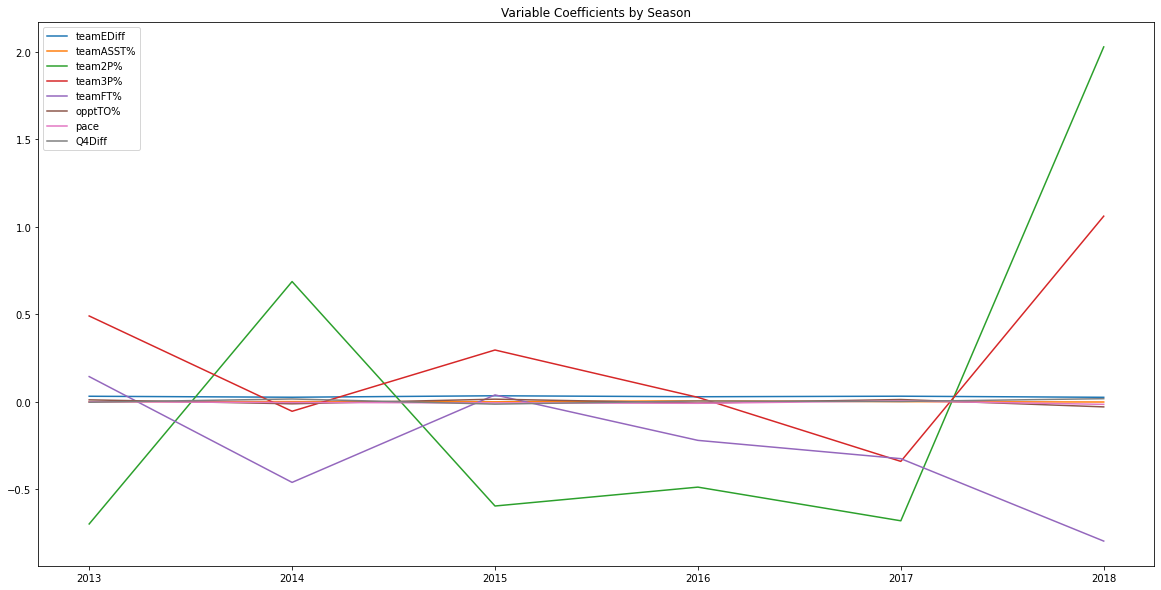

In [ ]:
# initialize storage list
szn_list = []
teamEDiff_list = []
teamASST_list = []
team2P_list = []
team3P_list = []
teamFT_list = []
opptT0_list = []
pace_list = []
Q4Diff_list = []

# initialize compact list
coeff_list = [teamEDiff_list, teamASST_list, team2P_list, team3P_list, teamFT_list, opptT0_list, pace_list, Q4Diff_list]

# isolate the coefficients
for szn in range(2013, 2019): 
  szn_list.append(szn)
  for idx in range(0, 8):
    coeff_list[idx].append(coeff_df.iloc[idx][str(szn)])

# Plot! 
plt.figure(figsize=(20, 10))

# iterate through each category and plot a line on the graph 
for idx in range(0, 8): 
  plt.plot(szn_list, coeff_list[idx], label=STATS[idx])

# include legend and title
plt.legend(loc="upper left")
plt.title("Variable Coefficients by Season")

plt.show()

# Conclusion


**Overview**

From our results, we observe the following: 

*   In general, it can be seen that teamEDiff, teamASST%, opptTO%, pace, and Q4Diff do not significantly impact the outcome of a game especially when compared to team2P%, team3P%, and teamFT% during 2013-2018. 

*   The lack of impact from teamEDiff, teamASST%, opptTO%, pace, and Q4Diff on the outcomes are consistent throughout the seasons, whereas the impact caused by team2P%, team3P%, and teamFT% are relatively inconsistent across the years.

*   team2P% and team3P% were especially significant in 2018, possibly signaling a trend towards the importance of a team's FG% in winning games in the future compared to a team's ASST% or FT%.

*   By hand-calculation, there is roughly an average of 42.99% mean squared error in our seasonal prediction for win rate, which translates to a average root mean squared error of 6.56%. 

**Limitation**

By far, the largest limitation we have for this analysis is the sample size. Although the original dataset provides 14758 games worth of statistics, the prediction for win rate cannot be based on any singular game alone. The most logical way to group games in these conditions would be by professional teams. This decision was made since games played by the same professional team should, theoretically, display dependency on one another. 

Furthermore, the total player pool changes from season to season. Thus, it would not make sense to compare a game from 2014 to one in 2017. As a result, we subsetted the data off by season and split the data into a training and testing set within each subset. 

All of this subsets led us to a sample of 30 teams for each cycle of modeling and predictions. This sample is very limited and, thus, very difficult to draw concrete conclusions from. 

**Future Studies**

There is nothing as unpredictable as the world of sports. From "The Miracle on Ice" to the Warriors blowing a 3-1 lead, where there is sport, there is a chance for the impossible. Although we can never truly predict the outcome of a game, there are many different questions that we can ask to expand on our research, such as:


*   How does our research in the NBA game compare to that of the college game where the reigning National Champion (Virginia) also had the fewest possessions of any D-1 team?
*   Why do the coefficients change so much between seasons? Can we find more constant variables?
*   How does our research translate to other sports?

There will always be more questions to ask regarding sports prediction, but hopefully we can answer a few of them. See you in Vegas.



**Learned**

From this project, our team learned valuable techniques in manipulating dataset and gained hands-on experience with the data science pipeline. 

* We learned to manipulate dataset with **pandas**, a powerful python library used for structuring data. Specifically, we subsetted the original dataframe of NBA box scores into only the categories (by explanatory variables or by teams) that we needed for the analysis. Additionally, we also created new columns, season and win/loss, from existing columns within the dataset. 

* We learned to create a multivariate linear model from our training datasets with **scikit-learn**, a python library used for machine learning. By feeding data into the model, we effectively extracted the coefficients, win rate predictions, and MSE of our model and presented them cleanly in the form of dataframes. Furthermore, we automated this process with a function to ease understanding of our output and code from an outsider's perspective. 

* Lastly, we learned to create a visual representation of the change in our coefficients over time with **matplotlib**, a python library frequently used for plotting data. 




**Special Thanks**

We would like to thank **Melinda** and **Cole** for the bi-weekly DEEP workshops and provided notebooks that allowed for a streamlined learning experience with the data science pipeline. 

AND MASSIVE thanks to **Jason**, our mentor, for always being present to provide advice and directions for our project. Without his consideration for everyone's time availability, his encouragement for our continuing effort, and his attention towards our individual understanding of all the processes within this notebook, this project would not have been possible. 